In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from keras.layers import Bidirectional
test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
from sklearn.metrics import r2_score,mean_squared_error 

Using TensorFlow backend.


In [2]:
data=pd.read_csv('dataset/iron_oildaily.csv',parse_dates=['date'])

In [3]:
data = data.dropna()

In [4]:
data = data.reset_index(drop = True)

In [5]:
new_data = pd.DataFrame(columns=['date','iron_price','oil_price'])
new_data['date'] = data.date
new_data['iron_price'] = data.Price
new_data['oil_price'] = data.oildata

In [6]:
new_data.head()

,date,iron_price,oil_price
0,2010-10-25,145.0,80.03
1,2010-10-26,145.1,79.75
2,2010-10-27,144.5,79.19
3,2010-10-28,144.0,79.92
4,2010-10-29,147.5,79.42


In [7]:
#data['Price'].plot()
new_data['oil_price_lag']=new_data['oil_price'].shift(1)
new_data=new_data.set_index('date')
new_data['rolling_mean_price']=new_data['oil_price_lag'].rolling(2, min_periods=1).sum()
new_data=new_data.dropna()

In [8]:
split_date = '2019-05-01'
test_value_store = new_data[split_date:] #2121
test_value_store.iron_price.values

array([93.65, 93.6 , 93.81, 93.51, 94.75, 94.19, 94.24, 95.08, 94.38,
       93.88, 94.82, 96.13, 96.34, 96.38, 96.56, 97.04, 97.31, 98.14,
       98.38, 98.59, 98.72, 98.76])

In [9]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['oil_price'] = min_max_scaler.fit_transform(df.oil_price.values.reshape(-1,1))
    df['oil_price_lag'] = min_max_scaler.fit_transform(df.oil_price_lag.values.reshape(-1,1))
    df['iron_price'] = min_max_scaler.fit_transform(df.iron_price.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [10]:
# normalize stock
df = new_data.copy()
df = normalize_data(df)
df.head()

,iron_price,oil_price,oil_price_lag,rolling_mean_price
date,,,,
2010-10-26,0.708699,0.560591,0.563332,0.170227
2010-10-27,0.704709,0.555110,0.560591,0.561908
2010-10-28,0.701383,0.562255,0.555110,0.557782
2010-10-29,0.724661,0.557361,0.562255,0.558617
2010-11-01,0.714685,0.568422,0.557361,0.559747


In [11]:
train = df[:split_date]
test = df[split_date:]

In [12]:
train.tail()

,iron_price,oil_price,oil_price_lag,rolling_mean_price
date,,,,
2019-04-25,0.363128,0.504699,0.498727,0.498158
2019-04-26,0.363262,0.488449,0.504699,0.501449
2019-04-29,0.363328,0.475626,0.488449,0.496292
2019-04-30,0.363794,0.483849,0.475626,0.481705
2019-05-01,0.366520,0.484730,0.483849,0.479397


In [13]:
test.head()

,iron_price,oil_price,oil_price_lag,rolling_mean_price
date,,,,
2019-05-01,0.366520,0.484730,0.483849,0.479397
2019-05-02,0.366188,0.474745,0.484730,0.483964
2019-05-03,0.367584,0.471124,0.474745,0.479397
2019-05-06,0.365589,0.467404,0.471124,0.472570
2019-05-07,0.373836,0.469558,0.467404,0.468887


In [14]:
print(len(train), len(test))

2126 22


In [15]:
train_data_raw = train.as_matrix()
test_data_raw = test.as_matrix()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [16]:
print("train data shape = ", train_data_raw.shape)
print("test data shape = ",test_data_raw.shape)

train data shape =  (2126, 4)
test data shape =  (22, 4)


In [17]:
train_data_raw

array([[0.70869912, 0.56059123, 0.56333203, 0.1702274 ],
       [0.7047087 , 0.55510963, 0.56059123, 0.56190757],
       [0.70138335, 0.56225529, 0.55510963, 0.55778203],
       ...,
       [0.36332801, 0.47562647, 0.48844949, 0.49629193],
       [0.36379356, 0.48384886, 0.47562647, 0.48170522],
       [0.36652035, 0.48472984, 0.48384886, 0.47939689]])

In [18]:
x_train = train_data_raw[:,1:] #without Iron price column of train
y_train = train_data_raw[:,0] #Only Iron price column of train

x_test = test_data_raw[:,1:] #without Iron price column of test
y_test = test_data_raw[:,0]  #Only Iron price column of test

In [19]:
x_train

array([[0.56059123, 0.56333203, 0.1702274 ],
       [0.55510963, 0.56059123, 0.56190757],
       [0.56225529, 0.55510963, 0.55778203],
       ...,
       [0.47562647, 0.48844949, 0.49629193],
       [0.48384886, 0.47562647, 0.48170522],
       [0.48472984, 0.48384886, 0.47939689]])

In [20]:
train_data_raw

array([[0.70869912, 0.56059123, 0.56333203, 0.1702274 ],
       [0.7047087 , 0.55510963, 0.56059123, 0.56190757],
       [0.70138335, 0.56225529, 0.55510963, 0.55778203],
       ...,
       [0.36332801, 0.47562647, 0.48844949, 0.49629193],
       [0.36379356, 0.48384886, 0.47562647, 0.48170522],
       [0.36652035, 0.48472984, 0.48384886, 0.47939689]])

In [21]:
# def denormalize(df, normalized_value): 
#     df = df['Price'].values.reshape(-1,1)
#     print(df[:5])
#     normalized_value = normalized_value.reshape(-1,1)
#     #return df.shape, p.shape
#     print(normalized_value[0:5])
#     min_max_scaler = sklearn.preprocessing.MinMaxScaler()
#     a = min_max_scaler.fit_transform(df)
#     print(a[:5])
#     new = min_max_scaler.inverse_transform(normalized_value)
#     print(new[:10])
#     return new

# #newp = denormalize(test_value_store, pred_price)
# newy_test = denormalize(data, y_test)

In [22]:
test_value_store.iron_price.values

array([93.65, 93.6 , 93.81, 93.51, 94.75, 94.19, 94.24, 95.08, 94.38,
       93.88, 94.82, 96.13, 96.34, 96.38, 96.56, 97.04, 97.31, 98.14,
       98.38, 98.59, 98.72, 98.76])

In [23]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2126, 3)
y_train.shape =  (2126,)
x_test.shape =  (22, 3)
y_test.shape =  (22,)


In [24]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))
#x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_test.shape[1]))
x_test.shape

(22, 1, 3)

In [25]:
(train_dim, train_timestep , train_feat) = x_train.shape
(test_dim, test_timestep , test_feat) = x_test.shape

In [26]:
print("Build Model")
"""
model = Sequential()

model.add(LSTM(32, input_shape=(train_timestep,train_feat), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32, input_shape=(train_timestep,train_feat), return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)
"""
model = Sequential()

model.add(Bidirectional(LSTM(32, input_shape=(train_timestep,train_feat), return_sequences=False)))
#model.add(Dropout(d))

model.add(Dense(16,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)

Build Model
Compilation Time :  0.04584026336669922


In [27]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,batch_size = 1,epochs=20,shuffle=False)


Epoch 1/20
2126/2126 [==============================] - 4s 2ms/step - loss: 0.0185 - accuracy: 9.4073e-04
Epoch 2/20
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0018 - accuracy: 9.4073e-04
Epoch 3/20
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0019 - accuracy: 9.4073e-04
Epoch 4/20
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0026 - accuracy: 9.4073e-04
Epoch 5/20
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0169 - accuracy: 9.4073e-04
Epoch 6/20
2126/2126 [==============================] - 3s 2ms/step - loss: 0.0228 - accuracy: 9.4073e-04
Epoch 7/20
2126/2126 [==============================] - 3s 1ms/step - loss: 0.0246 - accuracy: 4.7037e-04
Epoch 8/20
2126/2126 [==============================] - 3s 2ms/step - loss: 0.0252 - accuracy: 4.7037e-04
Epoch 9/20
2126/2126 [==============================] - 3s 2ms/step - loss: 0.0253 - accuracy: 4.7037e-04
Epoch 10/20
2126/2126 [======================

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 64)                9216      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 10,273
Trainable params: 10,273
Non-trainable params: 0
_________________________________________________________________


In [29]:
# serialize model to JSON
model_json = model.to_json()
with open("model-weight/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-weight/model.h5")
print("Saved model to disk")

Saved model to disk


In [30]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [31]:
pred_price = model.predict(x_test,batch_size=1,verbose=1)

22/22 [==============================] - 0s 7ms/step


In [32]:
pred_price

array([[0.42904583],
       [0.42766744],
       [0.42401657],
       [0.42111507],
       [0.42021945],
       [0.41912046],
       [0.4171796 ],
       [0.41842034],
       [0.42236027],
       [0.42353338],
       [0.42392606],
       [0.42829242],
       [0.4325018 ],
       [0.43339452],
       [0.431302  ],
       [0.42749402],
       [0.4189888 ],
       [0.40846726],
       [0.40626535],
       [0.40665582],
       [0.40328056],
       [0.39299902]], dtype=float32)

In [33]:
def denormalize(df, normalized_value): 
    df = df['Price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(data, pred_price)
newy_test = denormalize(data, y_test)

In [34]:
test_value_store.iron_price.values

array([93.65, 93.6 , 93.81, 93.51, 94.75, 94.19, 94.24, 95.08, 94.38,
       93.88, 94.82, 96.13, 96.34, 96.38, 96.56, 97.04, 97.31, 98.14,
       98.38, 98.59, 98.72, 98.76])

In [35]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.02957 MSE (0.17 RMSE)
Test Score: 0.00191 MSE (0.04 RMSE)


(0.029574900225982394, 0.0019105823012068868)

In [36]:
act_pred = pd.concat([pd.DataFrame(test_value_store.oil_price.values),pd.DataFrame(newy_test),pd.DataFrame(newp)], axis=1) 
act_pred.columns = ['Actual_Oil_Price','Actual_Iron_Price','Predicted_Iron_Price']

In [37]:
act_pred['date'] = test_value_store.index

In [38]:
act_pred = act_pred.set_index('date')
act_pred

,Actual_Oil_Price,Actual_Iron_Price,Predicted_Iron_Price
date,,,
2019-05-01,72.00,93.65,103.051331
2019-05-02,70.98,93.60,102.844070
2019-05-03,70.61,93.81,102.295135
2019-05-06,70.23,93.51,101.858864
2019-05-07,70.45,94.75,101.724197
2019-05-08,69.88,94.19,101.558952
2019-05-09,69.66,94.24,101.267128
2019-05-10,70.66,95.08,101.453682
2019-05-13,71.21,94.38,102.046089


In [39]:
#test_value_store

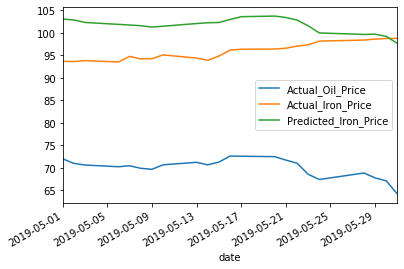

In [40]:
act_pred.plot()

In [41]:
def perd_accuracy(pred, actual):
    mape=np.mean(np.abs(pred-actual)/np.abs(actual))# MAPE
    me=np.mean(pred-actual)# ME
    mae=np.mean(np.abs(pred-actual))# MAE
    mpe=np.mean((pred-actual)/actual)# MPE
    return({'mape':mape,'me':me,'mae': mae,'mpe': mpe})
print(perd_accuracy(act_pred.Predicted_Iron_Price.values,act_pred.Actual_Iron_Price.values))

{'mape': 0.0625034174858227, 'me': 5.835542602539063, 'mae': 5.938148748224432, 'mpe': 0.06146447311881815}


In [42]:
# In normalize condition
# new_df = pd.DataFrame(columns=['actual_price','predict_price'])
# new_df['actual_price'] = act_pred['Actual'].values
# new_df['predict_price'] = act_pred['Predicted'].values
# new_df.plot(figsize=(15,5))
# plt.ylabel("Price")